In [1]:
import yfinance as yf
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.svm import SVR

gold = yf.download('GC=F ', '2022-03-01', '2024-03-01', auto_adjust=True)

print(gold)

[*********************100%***********************]  1 of 1 completed
                   Open         High          Low        Close  Volume
Date                                                                  
2022-03-01  1908.300049  1942.400024  1903.800049  1942.400024     547
2022-03-02  1945.599976  1948.199951  1919.800049  1920.900024     109
2022-03-03  1930.500000  1940.300049  1924.800049  1934.400024     122
2022-03-04  1937.000000  1970.900024  1935.599976  1965.099976      47
2022-03-07  1989.000000  2001.099976  1963.000000  1993.900024    2516
...                 ...          ...          ...          ...     ...
2024-02-23  2026.000000  2038.599976  2014.900024  2038.599976      22
2024-02-26  2034.099976  2035.400024  2024.800049  2028.500000     143
2024-02-27  2035.900024  2035.900024  2034.000000  2034.000000     964
2024-02-28  2029.500000  2037.000000  2024.800049  2033.000000     581
2024-02-29  2034.300049  2049.800049  2034.300049  2045.699951     706

[504 ro

In [2]:
# Tính trung bình của high và low
gold['mean_day'] = (gold['High'] + gold['Low']) / 2

# In ra một số dòng đầu của DataFrame để kiểm tra
print(gold.head())


                   Open         High          Low        Close  Volume  \
Date                                                                     
2022-03-01  1908.300049  1942.400024  1903.800049  1942.400024     547   
2022-03-02  1945.599976  1948.199951  1919.800049  1920.900024     109   
2022-03-03  1930.500000  1940.300049  1924.800049  1934.400024     122   
2022-03-04  1937.000000  1970.900024  1935.599976  1965.099976      47   
2022-03-07  1989.000000  2001.099976  1963.000000  1993.900024    2516   

               mean_day  
Date                     
2022-03-01  1923.100037  
2022-03-02  1934.000000  
2022-03-03  1932.550049  
2022-03-04  1953.250000  
2022-03-07  1982.049988  


19:16:33 - cmdstanpy - INFO - Chain [1] start processing
19:16:33 - cmdstanpy - INFO - Chain [1] done processing


            ds         yhat
559 2024-04-25  2083.573159
560 2024-04-26  2082.551906
561 2024-04-27  2071.776119
562 2024-04-28  2069.191168
563 2024-04-29  2072.269978


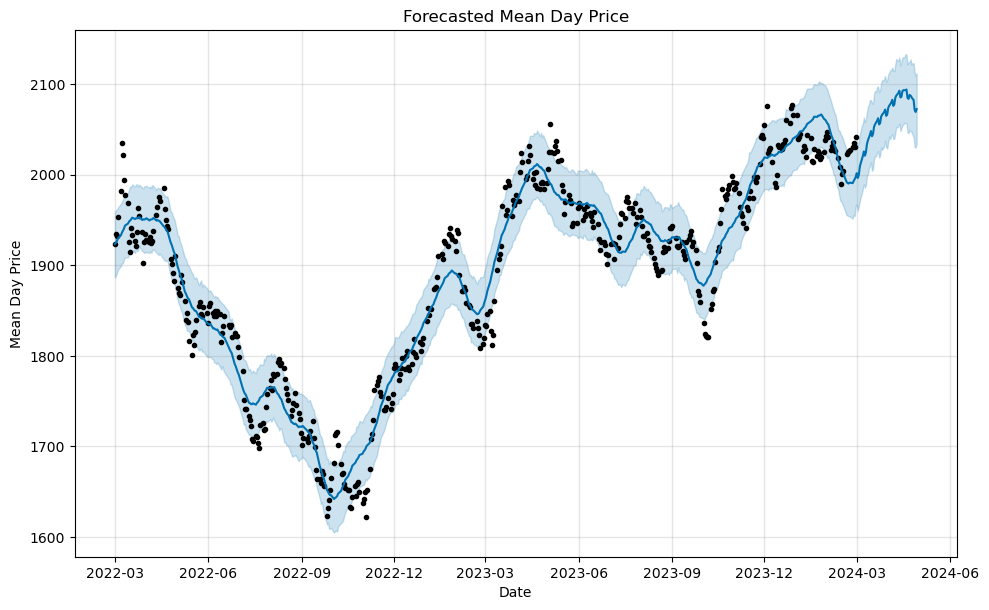

In [6]:
from prophet import Prophet
import matplotlib.pyplot as plt

# Chuẩn bị dữ liệu cho Prophet
gold_prophet = gold.reset_index()[['Date', 'mean_day']]
gold_prophet.columns = ['ds', 'y']

# Tạo và fit mô hình Prophet
M1 = Prophet()
M1.fit(gold_prophet)

# Dự báo giá trung bình trong tương lai
future = M1.make_future_dataframe(periods=60)  # Dự báo 60 ngày tiếp theo
M1Out = M1.predict(future)

# In ra dự báo cho 5 dòng cuối cùng
print(M1Out[['ds', 'yhat']].tail())

# Vẽ biểu đồ dự báo
M1.plot(M1Out)
plt.xlabel('Date')
plt.ylabel('Mean Day Price')
plt.title('Forecasted Mean Day Price')
plt.show()


M2

In [4]:
def calculate_sar(df, acceleration=0.02, maximum=0.2):
    high = df['High']
    low = df['Low']
    sar = pd.Series(index=df.index)
    sar[0] = low[0]
    trend = 0
    ep = 0
    af = acceleration
    for i in range(1, len(df)):
        if trend == 0:
            if high[i - 1] > high[i] and low[i - 1] > low[i]:
                trend = 1
                sar[i] = low[i]
                ep = high[i]
                af = acceleration
            elif high[i - 1] < high[i] and low[i - 1] < low[i]:
                trend = -1
                sar[i] = high[i]
                ep = low[i]
                af = acceleration
        else:
            if trend == 1:
                if high[i] > ep:
                    sar[i] = sar[i - 1] + af * (ep - sar[i - 1])
                    sar[i] = min(sar[i], low[i - 1])
                    ep = high[i]
                    af = min(af + acceleration, maximum)
                else:
                    trend = -1
                    sar[i] = ep
                    sar[i] = min(sar[i], low[i - 1])
                    sar[i] = min(sar[i], low[i])
                    ep = low[i]
                    af = acceleration
            elif trend == -1:
                if low[i] < ep:
                    sar[i] = sar[i - 1] + af * (ep - sar[i - 1])
                    sar[i] = max(sar[i], high[i - 1])
                    ep = low[i]
                    af = min(af + acceleration, maximum)
                else:
                    trend = 1
                    sar[i] = ep
                    sar[i] = max(sar[i], high[i - 1])
                    sar[i] = max(sar[i], high[i])
                    ep = high[i]
                    af = acceleration
    return sar


In [7]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
# Tính toán SAR cho dữ liệu và thêm vào DataFrame
gold['SAR'] = calculate_sar(gold)

# Chuẩn bị dữ liệu cho mô hình LSTM
data = gold[['mean_day', 'SAR']].copy()
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Hàm tạo dữ liệu cho mô hình LSTM
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), :])
        Y.append(dataset[i + look_back, 1])
    return np.array(X), np.array(Y)

# Thiết lập siêu tham số
look_back = 30
batch_size = 32
epochs = 100

# Tạo dữ liệu train và test
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train, test = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# Reshape dữ liệu
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

# Xây dựng mô hình LSTM
M2 = Sequential()
M2.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))
M2.add(LSTM(units=50))
M2.add(Dense(units=1))

# Compile mô hình
M2.compile(optimizer='adam', loss='mean_squared_error')

# Fit mô hình
M2.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=2)

C:\Users\My My\AppData\Local\Temp\ipykernel_15268\139983423.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  sar = pd.Series(index=df.index)


Epoch 1/100
12/12 - 6s - loss: 0.1440 - 6s/epoch - 494ms/step
Epoch 2/100
12/12 - 0s - loss: 0.0176 - 364ms/epoch - 30ms/step
Epoch 3/100
12/12 - 1s - loss: 0.0115 - 550ms/epoch - 46ms/step
Epoch 4/100
12/12 - 0s - loss: 0.0087 - 340ms/epoch - 28ms/step
Epoch 5/100
12/12 - 0s - loss: 0.0073 - 347ms/epoch - 29ms/step
Epoch 6/100
12/12 - 0s - loss: 0.0063 - 380ms/epoch - 32ms/step
Epoch 7/100
12/12 - 1s - loss: 0.0058 - 585ms/epoch - 49ms/step
Epoch 8/100
12/12 - 0s - loss: 0.0054 - 362ms/epoch - 30ms/step
Epoch 9/100
12/12 - 0s - loss: 0.0052 - 358ms/epoch - 30ms/step
Epoch 10/100
12/12 - 0s - loss: 0.0050 - 321ms/epoch - 27ms/step
Epoch 11/100
12/12 - 0s - loss: 0.0047 - 352ms/epoch - 29ms/step
Epoch 12/100
12/12 - 0s - loss: 0.0045 - 394ms/epoch - 33ms/step
Epoch 13/100
12/12 - 0s - loss: 0.0043 - 380ms/epoch - 32ms/step
Epoch 14/100
12/12 - 0s - loss: 0.0041 - 412ms/epoch - 34ms/step
Epoch 15/100
12/12 - 0s - loss: 0.0039 - 491ms/epoch - 41ms/step
Epoch 16/100
12/12 - 0s - loss: 0.00

In [15]:
# Extract the relevant column ('yhat') from the Prophet output (M1Out)
prophet_predictions = M1Out[len(M1Out)-30:]['yhat'].values.reshape(-1, 1)

# Create a dummy feature to match the expected input shape of the MinMaxScaler
dummy_feature = np.zeros_like(prophet_predictions)

# Concatenate the 'yhat' column with the dummy feature
combined_data = np.concatenate([prophet_predictions, dummy_feature], axis=1)

# Scale the data using the same scaler used for training the LSTM model
scaled_data = scaler.transform(combined_data)

# Reshape the data to match the input shape expected by the LSTM model
scaled_data = scaled_data.reshape(1, len(scaled_data), 2)

# Make predictions using the LSTM model
M2Out = M2.predict(scaled_data)

# Inverse transform the predicted values to get the original scale
M2Out = scaler.inverse_transform(M2Out)

print(M2Out)

1/1 [==============================] - 0s 63ms/step


c:\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


ValueError: non-broadcastable output operand with shape (1,1) doesn't match the broadcast shape (1,2)